In [1]:
import pickle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import tempfile
import os
import zipfile
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
#importando a base de dados
data = pickle.load(open("data/all.pkl", "rb"))
images = data["images"]
label = data["targets"]

In [3]:
#separando treino, teste e validação
x_train, x_test, y_train, y_test = train_test_split(images, label, test_size=0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5)

In [4]:
#convertendo o formato de NCHW para NHWC
x_train = x_train.reshape((x_train.shape[0], x_train.shape[3], x_train.shape[2], x_train.shape[1]))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[3], x_valid.shape[2], x_valid.shape[1]))
x_test= x_test.reshape((x_test.shape[0], x_test.shape[3], x_test.shape[2], x_test.shape[1]))

In [5]:
#definindo parâmetros da parada antecipada
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [6]:
model = Sequential()  
    
model.add(Conv2D(64, (3,3), input_shape = (51, 51, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), data_format='channels_last'))

model.add(Conv2D(64, (3,3), input_shape = (51, 51, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), data_format='channels_last'))

model.add(Flatten())
    
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2)) 

model.add(Dense(units = 1, activation = 'sigmoid'))
    
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [7]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 128, validation_data = (x_valid, y_valid),  callbacks=[es, mc])

Epoch 1/30
4892/4892 [==============================] - 1888s 385ms/step - loss: 0.2311 - accuracy: 0.9284 - val_loss: 0.1586 - val_accuracy: 0.9358

Epoch 00001: val_accuracy improved from -inf to 0.93584, saving model to best_model.h5
Epoch 2/30
4892/4892 [==============================] - 1810s 370ms/step - loss: 0.1222 - accuracy: 0.9569 - val_loss: 0.1236 - val_accuracy: 0.9559

Epoch 00002: val_accuracy improved from 0.93584 to 0.95594, saving model to best_model.h5
Epoch 3/30
4892/4892 [==============================] - 1828s 374ms/step - loss: 0.1090 - accuracy: 0.9617 - val_loss: 0.1084 - val_accuracy: 0.9614

Epoch 00003: val_accuracy improved from 0.95594 to 0.96144, saving model to best_model.h5
Epoch 4/30
4892/4892 [==============================] - 1824s 373ms/step - loss: 0.1012 - accuracy: 0.9648 - val_loss: 0.1100 - val_accuracy: 0.9614

Epoch 00004: val_accuracy did not improve from 0.96144
Epoch 5/30
4892/4892 [==============================] - 1803s 369ms/step - los

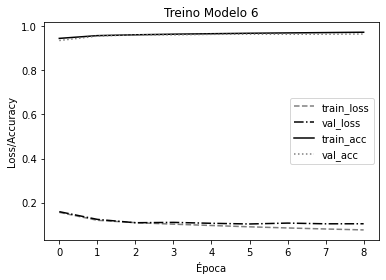

In [43]:
plt.figure()
plt.plot(np.arange(0,9), history.history["loss"], label="train_loss", linestyle='--', color="#7e7e7e")
plt.plot(np.arange(0,9), history.history["val_loss"], label="val_loss", linestyle='-.', color="#000")
plt.plot(np.arange(0,9), history.history["accuracy"], label="train_acc", linestyle='-', color="#000")
plt.plot(np.arange(0,9), history.history["val_accuracy"], label="val_acc",  linestyle=':', color="#7e7e7e")
plt.title("Treino Modelo 6")
plt.xlabel("Época")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('cnn.png', bbox_inches='tight')

In [9]:
predictions_model = model.predict(x_test)
predictions_model = (predictions_model>0.5)

In [10]:
matrix_model = confusion_matrix(y_test, predictions_model)
print(matrix_model)

[[65123  3071]
 [ 1347 64620]]


In [11]:
accuracy_model = accuracy_score(y_test, predictions_model)
print(accuracy_model)

0.9670694165964774


In [12]:
tf.keras.models.save_model(model, "models/model6.h5", include_optimizer=False)  

In [13]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

validation_split = 0.1
x_train.shape[0]

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / 128).astype(np.int32) * 3

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30, final_sparsity=0.80, begin_step=0, end_step=end_step)
}

#fazendo todo o modelo treinar com a poda
model_for_pruning = prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
]

D:\PROGRAMAS\Anaconda\envs\supernova\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [14]:
history_pruning = model_for_pruning.fit(x_train, y_train, batch_size=128, epochs=30, validation_data = (x_valid, y_valid), callbacks=callbacks)

Epoch 1/30
4892/4892 [==============================] - 1819s 371ms/step - loss: 0.0765 - accuracy: 0.9731 - val_loss: 0.1122 - val_accuracy: 0.9605

Epoch 00001: val_accuracy improved from -inf to 0.96047, saving model to best_model.h5
Epoch 2/30
4892/4892 [==============================] - 1839s 376ms/step - loss: 0.1036 - accuracy: 0.9636 - val_loss: 0.1166 - val_accuracy: 0.9605

Epoch 00002: val_accuracy improved from 0.96047 to 0.96050, saving model to best_model.h5
Epoch 3/30
4892/4892 [==============================] - 1881s 384ms/step - loss: 0.1102 - accuracy: 0.9616 - val_loss: 0.1127 - val_accuracy: 0.9605

Epoch 00003: val_accuracy improved from 0.96050 to 0.96055, saving model to best_model.h5
Epoch 4/30
4892/4892 [==============================] - 1868s 382ms/step - loss: 0.1043 - accuracy: 0.9633 - val_loss: 0.1090 - val_accuracy: 0.9626

Epoch 00004: val_accuracy improved from 0.96055 to 0.96256, saving model to best_model.h5
Epoch 5/30
4892/4892 [=====================

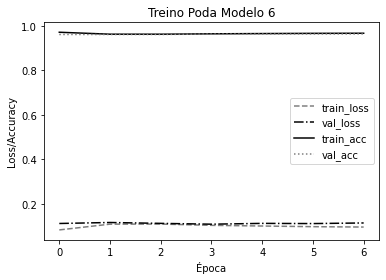

In [42]:
plt.figure()
plt.plot(np.arange(0,7), history_pruning.history["loss"], label="train_loss", linestyle='--', color="#7e7e7e")
plt.plot(np.arange(0,7), history_pruning.history["val_loss"], label="val_loss", linestyle='-.', color="#000")
plt.plot(np.arange(0,7), history_pruning.history["accuracy"], label="train_acc", linestyle='-', color="#000")
plt.plot(np.arange(0,7), history_pruning.history["val_accuracy"], label="val_acc",  linestyle=':', color="#7e7e7e")
plt.title("Treino Poda Modelo 6")
plt.xlabel("Época")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('cnn.png', bbox_inches='tight')

In [16]:
predictions_pruning = model_for_pruning.predict(x_test)
predictions_pruning = (predictions_pruning>0.5)

In [17]:
matrix_pruning = confusion_matrix(y_test, predictions_pruning)
print(matrix_pruning)

[[65500  2694]
 [ 2108 63859]]


In [18]:
accuracy_pruning = accuracy_score(y_test, predictions_pruning)
accuracy_pruning

0.9642071839059041

In [19]:
#strip_pruning remove parâmetros da poda que só são necessários durante o treinamento
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, "models/model_pruning6.h5", include_optimizer=False)

In [20]:
#converte para TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

pruned_tflite_file = 'models/model_pruning6.tflite'

#salva o modelo
with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Pichau\AppData\Local\Temp\tmpy_af673u\assets


In [21]:
#compacta os modelos via gzip e mede o tamanho compactado
def compacta_size(file):
  with zipfile.ZipFile('.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)
  return os.path.getsize('.zip')

In [22]:
print("Tamanho do modelo: %.2f bytes" % (compacta_size("models/model6.h5")))
print("Tamanho do modelo podado: %.2f bytes" % (compacta_size("models/model_pruning6.h5")))
print("Tamanho do modelo TFlite podado e compactado: %.2f bytes" % (compacta_size("models/model_pruning6.tflite")))

Tamanho do modelo: 3848056.00 bytes
Tamanho do modelo podado: 1223088.00 bytes
Tamanho do modelo TFlite podado e compactado: 1190586.00 bytes
